In [1]:
import utils
from config import config

import numpy as np
import os
import pickle
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline 

### Show Final Images

In [2]:
def aggregate(NNF, Ref, patch_size):
    
    Ref = Ref.astype(np.float)
    
    # Half-patch-size
    m = patch_size // 2
    
    # A [height, width, channels] tensor representing the resulting image
    out = np.zeros(shape=Ref.shape, dtype=Ref.dtype) 
    
    # For every pixel in the image, we smooth by aggregating every element in the patches
    for i in range(out.shape[0]):
        for j in range(out.shape[1]):
            
            # Gets the coordinates of the patch in Ref
            x = NNF[i,j,0]
            y = NNF[i,j,1]
            
            # Creates the limits of the patch
            x_begin = x - m
            x_end = x + m + 1
            y_begin = y - m
            y_end = y + m + 1
            
            # Makes sure those coordinates are valid [0, size-1]
            x_begin = max(x_begin, 0)
            x_end = min(x_end, out.shape[0])
            y_begin = max(y_begin, 0)
            y_end = min(y_end, out.shape[1])

            # Extracts the patch and reshapes it, and computes the mean across the spatial dimension
            patch = Ref[x_begin:x_end, y_begin:y_end, :]
            flat_patch = np.reshape(patch, newshape=(patch.shape[0]*patch.shape[1], patch.shape[2]))
            value = np.mean(flat_patch, axis=0)
            
            out[i,j,:] = value
                
    return out.astype(np.uint8)    

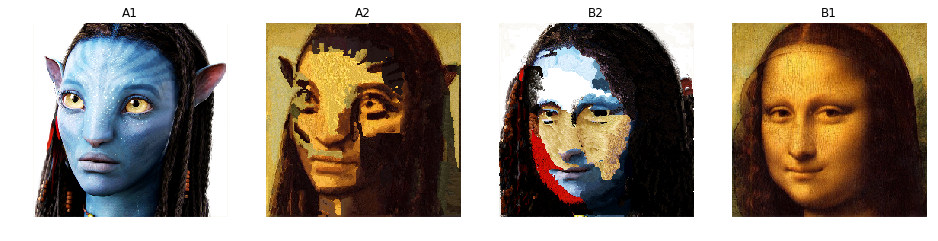

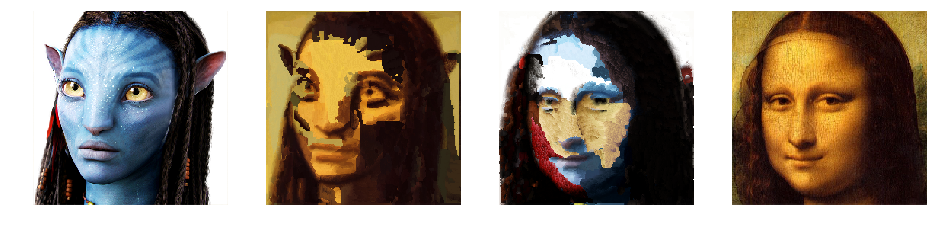

In [3]:
NNFs_ab = utils.loadNNFs(os.path.join('NNFs_ab.pkl'))
NNFs_ba = utils.loadNNFs(os.path.join('NNFs_ba.pkl'))

A1 = np.asarray(Image.open(os.path.join('Images', "avatar.png")).resize((config['img_size'],config['img_size'])))
B1 = np.asarray(Image.open(os.path.join('Images', "joconde.png")).resize((config['img_size'],config['img_size'])))

A2 = B1[NNFs_ab[1][:,:,0], NNFs_ab[1][:,:,1], :]
B2 = A1[NNFs_ba[1][:,:,0], NNFs_ba[1][:,:,1], :]

images = [A1, A2, B2, B1]
names = ['A1', 'A2', 'B2', 'B1']

# Displays the images
plt.figure(figsize=(16, 12))
for img, title, i in zip(images, names, list(range(4))):
    plt.subplot(1,4,i+1)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
plt.show()

# Aggregates the patches for final warping
A2_agg = aggregate(NNFs_ab[1], B1, config['patch_size'][1])
B2_agg = aggregate(NNFs_ba[1], A1, config['patch_size'][1])

images_agg = [A1, A2_agg, B2_agg, B1]

# Displays the aggregated images
plt.figure(figsize=(16, 12))
for img, i in zip(images_agg, list(range(4))):
    plt.subplot(1,4,i+1)
    plt.imshow(img)
    plt.axis("off")
plt.show()

### Show Feature Maps

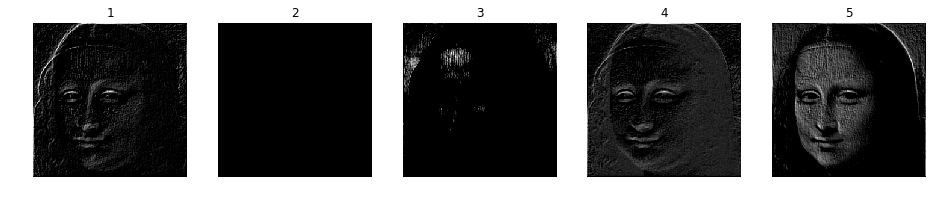

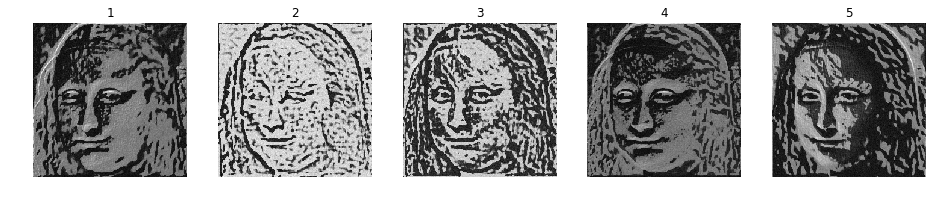

In [5]:
F_toLoad = [('B1',1), 
            ('B2',1),
           ]

# Displays the feature Maps
for (F_i, L_i) in F_toLoad:
    F = utils.loadFeatureMaps(os.path.join('featureMaps_' + F_i + '.pkl'))

    plt.figure(figsize=(16, 12))
    for f in range(5):
        plt.subplot(1,5,f+1)
        plt.imshow(F[L_i][:,:,f], cmap='gray')
        plt.title(str(f+1))
        plt.axis("off")
    plt.show()

### Show NNFs

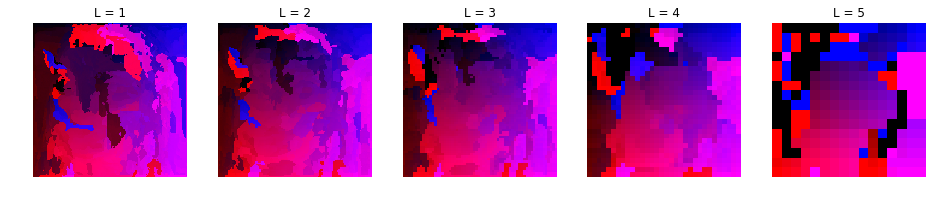

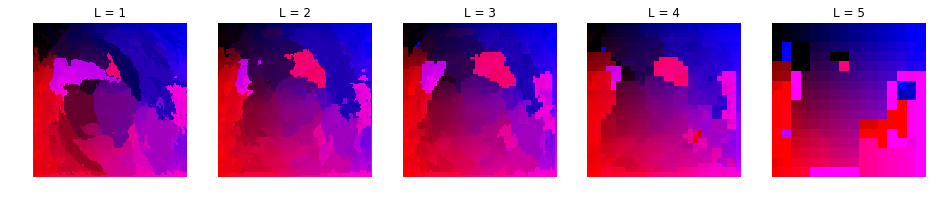

In [6]:
# Displays the NNF (mapping function)
NNFs_ab = utils.loadFeatureMaps(os.path.join('NNFs_ab.pkl'))
NNFs_ba = utils.loadFeatureMaps(os.path.join('NNFs_ba.pkl'))
All_NNFs = [NNFs_ab, NNFs_ba]

for NNFs in All_NNFs:

    plt.figure(figsize=(16, 12))
    for L in range(1,6):
        
        # Concatenate to RGB where G=zeros
        zeros = np.zeros(shape=(NNFs[L].shape[0], NNFs[L].shape[1], 1), dtype=NNFs[L].dtype)
        colorNNF = np.concatenate((np.expand_dims(NNFs[L][:,:,0], 2), zeros, np.expand_dims(NNFs[L][:,:,1], 2)), axis=2)
        colorNNF = (colorNNF / float(np.max(colorNNF))) * 255

        # Displays the NNFs for every layer L
        plt.subplot(1,5,L)
        plt.imshow(colorNNF.astype(np.uint8))
        plt.title("L = " + str(L))
        plt.axis("off")
    plt.show()